In [3]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
def customize_dataset(dataframe_raw, rand_str):
    print(ord(rand_str[0]), ord(rand_str[1]), ord(rand_str[2]))
    dataframe = dataframe_raw.copy(deep=True)

    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))

    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/ 100

    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100

    # drop column
    if ord(rand_str[3]) % 2 ==1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [7]:
my_name = 'enip'
dataframe = customize_dataset(dataframe_raw, my_name)
dataframe.head()

101 110 105


,age,sex,bmi,children,smoker,region,charges
44,38,male,40.7550,1,no,northeast,6383.655075
134,20,female,31.6635,0,no,northeast,2580.071708
980,54,male,28.0060,1,no,northeast,26792.969312
618,19,female,36.4210,0,yes,southeast,36161.848695
1238,37,male,24.9755,3,no,northeast,7334.782297


In [8]:
num_rows = len(dataframe)
num_cols = len(dataframe.columns)
print(num_cols, num_rows)

7 1271


In [9]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [10]:
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#fffbfa'

/home/divclab/anaconda3/envs/torch-env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


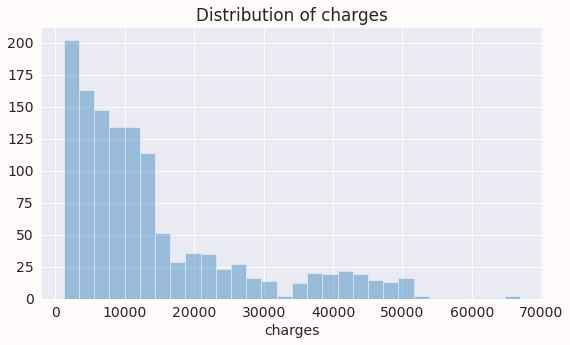

In [11]:
plt.title("Distribution of charges")

sns.distplot(dataframe.charges, kde=False);

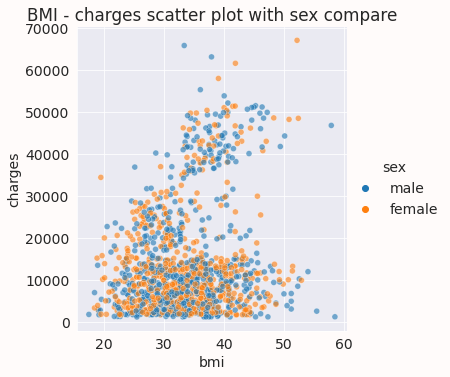

In [12]:
sns.relplot(data=dataframe, x='bmi', # X-axis
                y='charges', hue='sex',alpha=.6)\
    .set(title='BMI - charges scatter plot with sex compare')

<AxesSubplot:title={'center':'Age-Charge grpah with smoke or not'}, xlabel='age', ylabel='charges'>

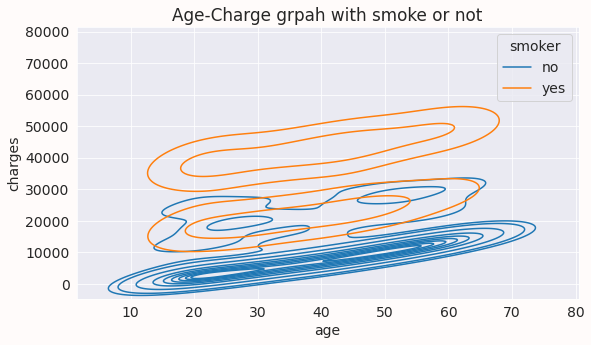

In [13]:
plt.title("Age-Charge grpah with smoke or not")
sns.kdeplot(x='age', data=dataframe,y='charges', hue="smoker")

/home/divclab/anaconda3/envs/torch-env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/divclab/anaconda3/envs/torch-env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, '')]

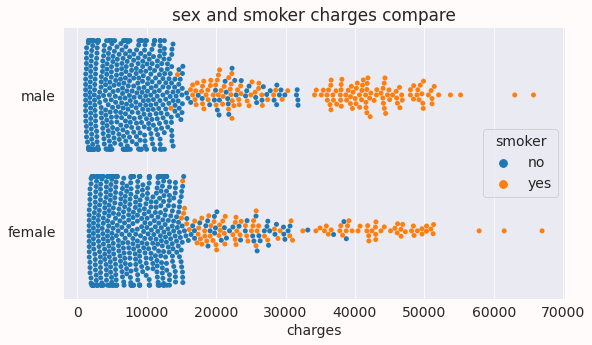

In [14]:
ax = sns.swarmplot(data=dataframe, x="charges", y="sex", hue="smoker")
ax.set_title('sex and smoker charges compare')
ax.set(ylabel="")

<AxesSubplot:title={'center':'children and charge population density'}, xlabel='Density', ylabel='charges'>

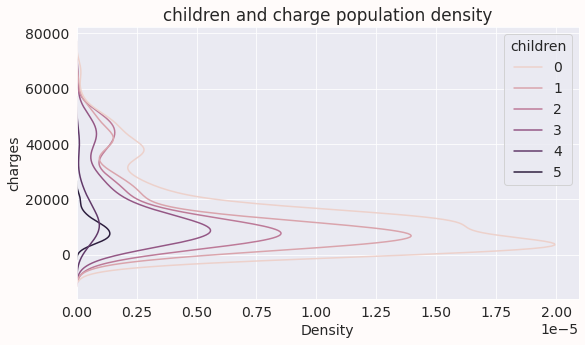

In [15]:
plt.title("children and charge population density")
sns.kdeplot(data=dataframe, y='charges', hue='children')

<AxesSubplot:title={'center':'Charge density with region'}, xlabel='Density', ylabel='charges'>

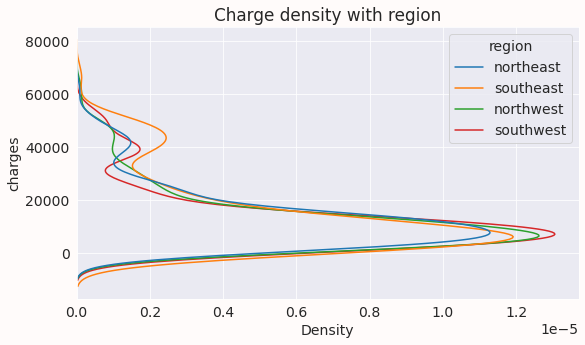

In [16]:
plt.title("Charge density with region")
sns.kdeplot(data=dataframe,y='charges', hue="region")


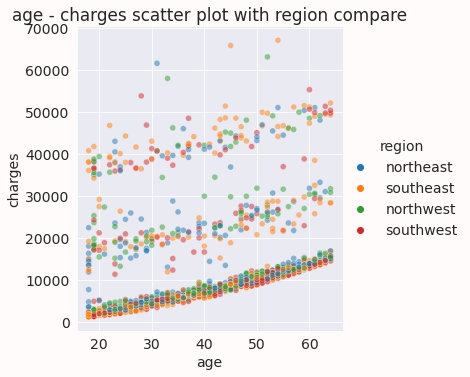

In [17]:
sns.relplot(data=dataframe, x='age', # X-axis
                y='charges', hue='region', alpha=.5)\
    .set(title='age - charges scatter plot with region compare')

In [243]:
input_cols = ['age', 'sex','bmi', 'children','smoker', 'region']
#input_cols = ['age','bmi','smoker', 'children']

categorical_cols = ['sex', 'region' ,'smoker']
output_cols = ['charges']


In [244]:
def dataframe_to_arrays(dataframe):
    dataframe1 = dataframe.copy(deep=True)

    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes

    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()

    return inputs_array, targets_array


In [245]:
inputs_arr, targets_arr = dataframe_to_arrays(dataframe)
inputs_arr, targets_arr


(array([[38.    , 40.755 ,  0.    ,  1.    ],
        [20.    , 31.6635,  0.    ,  0.    ],
        [54.    , 28.006 ,  0.    ,  1.    ],
        ...,
        [36.    , 30.514 ,  0.    ,  0.    ],
        [24.    , 30.36  ,  0.    ,  0.    ],
        [61.    , 35.53  ,  0.    ,  2.    ]]),
 array([[ 6383.655075 ],
        [ 2580.0717075],
        [26792.9693115],
        ...,
        [ 5742.45693  ],
        [19902.9811785],
        [14825.601    ]]))

In [246]:
inputs = torch.tensor(inputs_arr, dtype=torch.float32)
targets = torch.tensor(targets_arr, dtype=torch.float32)
inputs, targets

(tensor([[38.0000, 40.7550,  0.0000,  1.0000],
         [20.0000, 31.6635,  0.0000,  0.0000],
         [54.0000, 28.0060,  0.0000,  1.0000],
         ...,
         [36.0000, 30.5140,  0.0000,  0.0000],
         [24.0000, 30.3600,  0.0000,  0.0000],
         [61.0000, 35.5300,  0.0000,  2.0000]]),
 tensor([[ 6383.6553],
         [ 2580.0718],
         [26792.9688],
         ...,
         [ 5742.4570],
         [19902.9805],
         [14825.6006]]))

In [247]:
dataset = TensorDataset(inputs, targets)

In [248]:
val_percent = 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [413]:
batch_size = 8

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [250]:
for xb, yb in train_loader:
    print('Inputs:', len(xb))
    print('Targets:', len(yb))
    break

Inputs: 128
Targets: 128


In [251]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size, output_size

(4, 1)

In [316]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear (xb)
        return out

    def training_step(self, batch):
        inputs, targets = batch

        out = self(inputs)
        loss = F.mse_loss(out, targets)
        return loss

    def validation_step(self, batch):
        inputs, targets = batch

        out = self(inputs)
        loss = F.mse_loss(out, targets)

        return {'val_loss' : loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss' : epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 100 == 0 or epoch == num_epochs -1:
            print("Epoch [{:>3}/{}], val_loss: {:.4f}".format(epoch+1,epochs, result['val_loss']))

## Caution
You should reset the model(parameters)
after adjust hyper parameters.
or it would leave the old information

In [408]:
model = InsuranceModel()
history1 = []

In [318]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1345,  0.1846, -0.1318,  0.4339]], requires_grad=True),
 Parameter containing:
 tensor([-0.4176], requires_grad=True)]

In [319]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

print(evaluate(model, val_loader))

{'val_loss': 306366144.0}


In [381]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)

    return history

with batch=128
## Epochs
Epochs should > 1000 to reach overfitting

## Learning rate
lr > 0.0004 the gradient gonna explode
lr = 0.0003 is the fastest

if lr < 0.0001 would be too slow to train

In [415]:
epochs = 1000
lr = 1e-6

history1 += fit(epochs, lr, model, train_loader, val_loader)
print(len(history1))

Epoch [100/1000], val_loss: 34968092.0000
Epoch [200/1000], val_loss: 34905260.0000
Epoch [300/1000], val_loss: 34936192.0000
Epoch [400/1000], val_loss: 34920420.0000
Epoch [500/1000], val_loss: 35004320.0000
Epoch [600/1000], val_loss: 34984644.0000
Epoch [700/1000], val_loss: 34956288.0000
Epoch [800/1000], val_loss: 34933808.0000
Epoch [900/1000], val_loss: 34959420.0000
Epoch [1000/1000], val_loss: 34977264.0000
6000


<AxesSubplot:title={'center':'loss vs epoch'}, xlabel='epoch', ylabel='loss'>

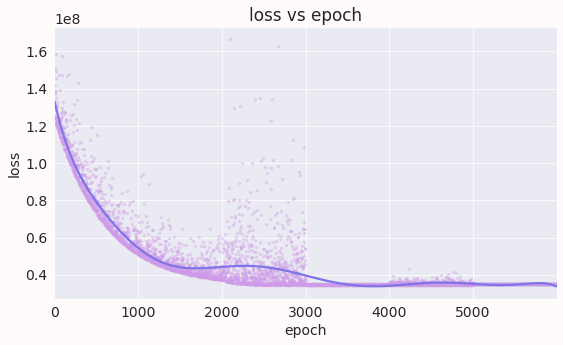

In [416]:
import numpy as np
import matplotlib.pyplot as plt
losses = [x['val_loss'] for x in history1]
# plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')

sns.regplot(x=np.arange(len(losses)), y=losses,
            order=10,
            color='#8074e8',
            scatter_kws={"s": 5, "color":"#cf9be8", "alpha":0.3},
            ci=None,
            truncate=True)

#sns.lineplot(data=losses, palette="tab10", linewidth=2.5)

In [417]:
val_loss = evaluate(model, val_loader)
print(val_loss)

{'val_loss': 34977264.0}


In [460]:
from termcolor import colored

def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()

    print('Input:\t', inputs)
    print('predict:', prediction.item())
    print('target:\t', target.item())

In [459]:
inputs, target = val_ds[12]
predict_single(inputs, target, model)

"red"
Input:	 tensor([[39.0000, 25.0800,  0.0000,  3.0000]]) 
predict: 8018.0634765625
target:	 8385.10546875


In [453]:
inputs, target = val_ds[54]
predict_single(inputs, target, model)

Input:	 tensor([[27.0000, 28.6330,  0.0000,  0.0000]])
predict: 4599.380859375
target:	 3224.34912109375


In [454]:
inputs, target = val_ds[78]
predict_single(inputs, target, model)

Input:	 tensor([[24.0000, 35.2110,  0.0000,  0.0000]])
predict: 5170.587890625
target:	 2080.660888671875


In [448]:
inputs, target = val_ds[103]
predict_single(inputs, target, model)


Input:	 tensor([[48.0000, 33.2200,  0.0000,  2.0000]])
predict: 11504.421875
target:	 9416.74609375
